In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

from graphviz import Source
from IPython.display import display



import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets


In [2]:
dowhy.__version__

'0.7.1'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

## 1. Matching with a confounder

### Read the data

In [4]:
earnings_data = pd.read_csv(r'./today-data/ml_earnings.csv')

In [5]:
earnings_data.shape

In [6]:
earnings_data.head()

,age,took_a_course,earnings
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [7]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

In [9]:
# Compute naive estimate 
treatment_avg = earnings_data.query('took_a_course==1')['earnings'].mean()
cntrl_avg = earnings_data.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

### Check True/False Ratio 

In [10]:
earnings_data.query('took_a_course==1')['earnings'].shape[0]/earnings_data.query('took_a_course==0')['earnings'].shape[0]

### Define the graph

In [11]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    print (gml_string)
    
gml_string += ']'

graph [directed 1
	node [id "took_a_course" label "took_a_course"]
	node [id "earnings" label "earnings"]
	node [id "age" label "age"]
	edge [source "took_a_course" target "earnings"]

graph [directed 1
	node [id "took_a_course" label "took_a_course"]
	node [id "earnings" label "earnings"]
	node [id "age" label "age"]
	edge [source "took_a_course" target "earnings"]
	edge [source "age" target "took_a_course"]

graph [directed 1
	node [id "took_a_course" label "took_a_course"]
	node [id "earnings" label "earnings"]
	node [id "age" label "age"]
	edge [source "took_a_course" target "earnings"]
	edge [source "age" target "took_a_course"]
	edge [source "age" target "earnings"]



In [12]:
gml_string

'graph [directed 1\n\tnode [id "took_a_course" label "took_a_course"]\n\tnode [id "earnings" label "earnings"]\n\tnode [id "age" label "age"]\n\tedge [source "took_a_course" target "earnings"]\n\tedge [source "age" target "took_a_course"]\n\tedge [source "age" target "earnings"]\n]'

In [13]:
network_G = nx.parse_gml(gml_string)
graphiz_dot = nx.nx_agraph.to_agraph(network_G)

In [14]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)


In [15]:
model.view_model()

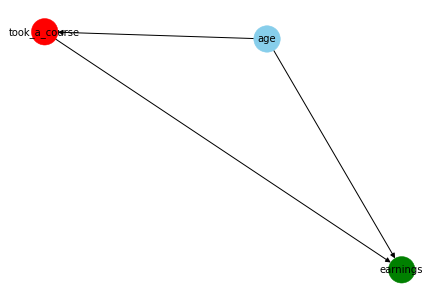

In [16]:
G = nx.parse_gml(gml_string)

# Draw the graph using Matplotlib
node_colors = ["red", "green", "skyblue"]
pos = nx.spring_layout(G)  # You can use different layout algorithms
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10)
plt.show()

### Get the estimand

In [17]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect
Treatment is a binary

In [18]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

distance_matching


In [19]:
estimate.value

### Refute
1. random common cause

In [20]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

In [21]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10333.75
New effect:10307.699299999998
p value:0.48



### Refute
2. Placebo treatment 

In [22]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute")

In [24]:
# p value is still greater than 0.05, our null hypothesis is good (alternative one is bad)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:10333.75
New effect:9.631000000000002
p value:0.44999999999999996



### Refute
3. Data subset refuter

In [25]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", subset_fraction=0.9)

In [26]:
print(refutation)

Refute: Use a subset of data
Estimated effect:10333.75
New effect:10350.350555555553
p value:0.5



### Summary:
None of retuter beat our null hypothesis which means that ....

### A friendly text interpreter, for ATE

In [27]:
# Textual Interpreter
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [took_a_course] from 0 to 1 causes an increase of 10333.75 in the expected value of the outcome [earnings], over the data distribution/population represented by the dataset.


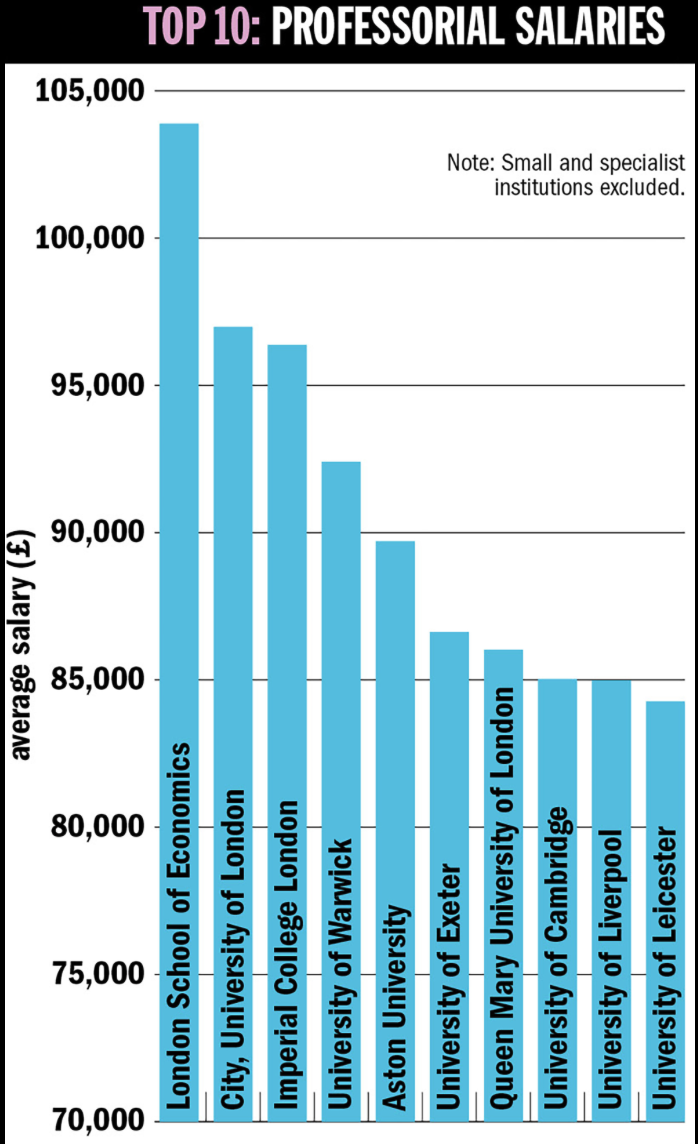

In [28]:
from IPython import display
display.Image("today-data/salary.png")

## 2. Maching with multiple confounders

In [29]:
data = dowhy.datasets.linear_dataset(beta=1,
        num_common_causes=5,
        num_instruments = 2,
        num_treatments=1,
        num_discrete_common_causes=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)

In [30]:
data

{'df':        Z0        Z1        W0        W1        W2        W3 W4     v0  \
 0     1.0  0.681633  0.664822  0.838571  2.554473 -2.542629  0   True   
 1     1.0  0.768523  0.564937  0.388677  0.184759 -2.006291  1   True   
 2     1.0  0.666319  0.225186  0.928248  0.617302  0.325422  3   True   
 3     0.0  0.467402  0.379017  0.583709  1.028341 -0.147902  1   True   
 4     0.0  0.006694 -0.660871  0.346303  0.266696 -0.898830  3   True   
 ...   ...       ...       ...       ...       ...       ... ..    ...   
 9995  0.0  0.674062  0.877640  0.808860  1.055980 -0.889152  2   True   
 9996  0.0  0.699413 -1.489177 -0.018598  0.090605 -1.601803  2  False   
 9997  1.0  0.576935 -0.820940  0.018073  2.320959 -0.735365  1   True   
 9998  1.0  0.429023 -1.167339  0.422927 -0.668880  0.857784  0   True   
 9999  1.0  0.335844  0.124284 -1.523601  1.808144 -1.852394  0   True   
 
              y  
 0     0.154182  
 1     0.415164  
 2     3.923650  
 3     2.327551  
 4     1.70245

In [31]:
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.681633,0.664822,0.838571,2.554473,-2.542629,0,True,0.154182
1,1.0,0.768523,0.564937,0.388677,0.184759,-2.006291,1,True,0.415164
2,1.0,0.666319,0.225186,0.928248,0.617302,0.325422,3,True,3.923650
3,0.0,0.467402,0.379017,0.583709,1.028341,-0.147902,1,True,2.327551
4,0.0,0.006694,-0.660871,0.346303,0.266696,-0.898830,3,True,1.702454
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.674062,0.877640,0.808860,1.055980,-0.889152,2,True,2.806440
9996,0.0,0.699413,-1.489177,-0.018598,0.090605,-1.601803,2,False,-1.514158
9997,1.0,0.576935,-0.820940,0.018073,2.320959,-0.735365,1,True,0.983198
9998,1.0,0.429023,-1.167339,0.422927,-0.668880,0.857784,0,True,0.582896


In [32]:
print(df[df.v0==True].shape[0])
print(df[df.v0==False].shape[0])

8708
1292


In [33]:
data["treatment_name"]

['v0']

In [31]:
data["outcome_name"]

'y'

In [34]:
data["common_causes_names"]

['W0', 'W1', 'W2', 'W3', 'W4']

In [35]:
data["instrument_names"]

['Z0', 'Z1']

In [36]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data['dot_graph'],
        instruments=data["instrument_names"]
        )


In [37]:
model.view_model()

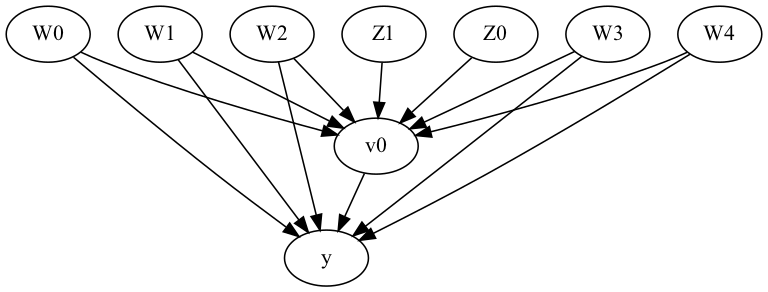

In [38]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

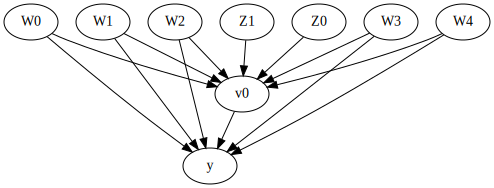

In [39]:
graph = Source(data['dot_graph'], format='png')
display(graph)

### Identify the problems in this network

In [40]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W1,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Stratification

### ATT, Propensity score matching

In [41]:
causal_estimate_strat_att = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat_att)
print("Causal Estimate is " + str(causal_estimate_strat_att.value))

propensity_score_stratification


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W1,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: att

## Estimate
Mean value: 1.0146384313057644

Causal Estimate is 1.0146384313057644


### ATC, Propensity score matching

In [43]:
causal_estimate_strat_atc = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="atc")
print(causal_estimate_strat_atc)
print("Causal Estimate is " + str(causal_estimate_strat_atc.value))

propensity_score_stratification


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W1,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: atc

## Estimate
Mean value: 1.0232855555285356

Causal Estimate is 1.0232855555285356


### ATE, Propensity score matching

In [44]:
causal_estimate_strat_ate = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate")
print(causal_estimate_strat_ate)
print("Causal Estimate is " + str(causal_estimate_strat_ate.value))

propensity_score_stratification


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W1,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: ate

## Estimate
Mean value: 1.0165265894447115

Causal Estimate is 1.0165265894447115


### A friendly text interpreter, for ATE

In [45]:
# Textual Interpreter
interpretation = causal_estimate_strat_ate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.0165265894447115 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


## Withtout Stratification. Just Propensity Score Matching

### Propensity score matching (without stratification, accepted broadly but there will be mismatching!)

In [46]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W1,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: ate

## Estimate
Mean value: 1.0413102150232223

Causal Estimate is 1.0413102150232223


### Stratification or Non-Stratification???
Stratification ATE: 1.0231096123399155, 
Non-Stratification ATE: 1.0192327749880936

### Wait, is it imbalanced?

In [44]:
print(df[df.v0==True].shape[0])
print(df[df.v0==False].shape[0])

8824
1176


## Inverse Probability Weighting (IPW)

In [47]:
causal_estimate_ipw_ate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw_ate)
print("Causal Estimate is " + str(causal_estimate_ipw_ate.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W1,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: ate

## Estimate
Mean value: 1.5216947427138974

Causal Estimate is 1.5216947427138974


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### A friendly text interpreter, for ATE

In [48]:
# Textual Interpreter
interpretation = causal_estimate_ipw_ate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.5216947427138974 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


### A friendly visual interpreter, for ATE

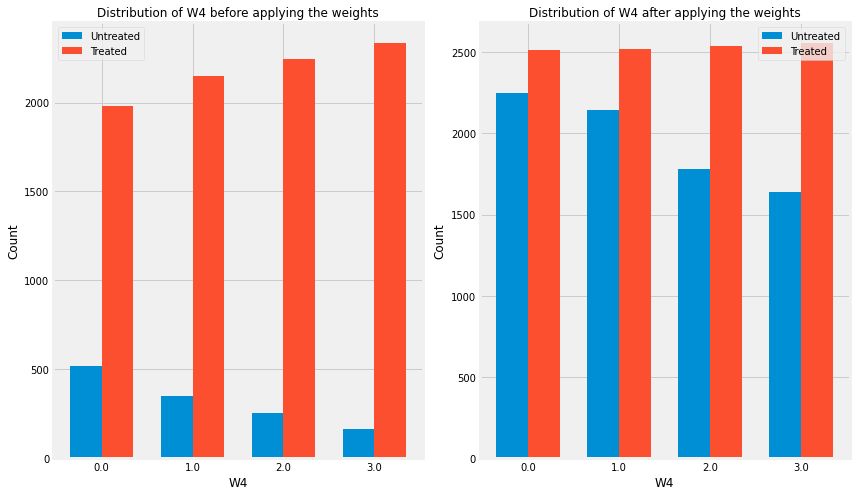

In [49]:
interpretation = causal_estimate_ipw_ate.interpret(method_name="confounder_distribution_interpreter", 
                                        fig_size=(12,7), font_size=12, var_name='W4', var_type='discrete')